In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = 'data/train'
valid_dir = 'data/valid'
test_dir = 'data/test'

In [3]:
filenames_train = []
label_train = []  
folds = os.listdir(train_dir)
for fold in folds: 
    FoldPath = os.path.join(train_dir, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filenames_train.append(filepath)
        label_train.append(fold)

100%|██████████| 1961/1961 [00:00<00:00, 433261.17it/s]


In [4]:
filenames_valid = []
label_valid = []
folds = os.listdir(valid_dir)
for fold in folds:
    FoldPath = os.path.join(valid_dir, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filenames_valid.append(filepath)
        label_valid.append(fold)

100%|██████████| 490/490 [00:00<00:00, 490152.39it/s]


# Creating DataFrames for training and validation data

In [5]:
df_train = pd.DataFrame({
    'filename': filenames_train,
    'label': label_train
})
df_valid = pd.DataFrame({
    'filename': filenames_valid,
    'label': label_valid
})

In [6]:
print(df_train.shape)
print(df_valid.shape)

(18345, 2)
(4585, 2)


In [7]:
df_train.head(5)

filename                    label
0  data/train\Tomato___Bacterial_spot\00416648-be...  Tomato___Bacterial_spot
1  data/train\Tomato___Bacterial_spot\0045ba29-ed...  Tomato___Bacterial_spot
2  data/train\Tomato___Bacterial_spot\00639d29-2d...  Tomato___Bacterial_spot
3  data/train\Tomato___Bacterial_spot\00728f4d-83...  Tomato___Bacterial_spot
4  data/train\Tomato___Bacterial_spot\00a7c269-34...  Tomato___Bacterial_spot

In [8]:
df_train.tail(5)

filename  \
18340  data/train\Tomato___Tomato_Yellow_Leaf_Curl_Vi...   
18341  data/train\Tomato___Tomato_Yellow_Leaf_Curl_Vi...   
18342  data/train\Tomato___Tomato_Yellow_Leaf_Curl_Vi...   
18343  data/train\Tomato___Tomato_Yellow_Leaf_Curl_Vi...   
18344  data/train\Tomato___Tomato_Yellow_Leaf_Curl_Vi...   

                                        label  
18340  Tomato___Tomato_Yellow_Leaf_Curl_Virus  
18341  Tomato___Tomato_Yellow_Leaf_Curl_Virus  
18342  Tomato___Tomato_Yellow_Leaf_Curl_Virus  
18343  Tomato___Tomato_Yellow_Leaf_Curl_Virus  
18344  Tomato___Tomato_Yellow_Leaf_Curl_Virus

In [9]:
df_train.sample(5)

filename  \
1993   data/train\Tomato___Early_blight\30c5bc48-7b5e...   
8091   data/train\Tomato___Leaf_Mold\74cdebf6-7aa9-40...   
14291  data/train\Tomato___Target_Spot\c413ab97-c72d-...   
6198   data/train\Tomato___Late_blight\4d9faab5-238d-...   
6545   data/train\Tomato___Late_blight\7da77ecf-90a8-...   

                       label  
1993   Tomato___Early_blight  
8091      Tomato___Leaf_Mold  
14291   Tomato___Target_Spot  
6198    Tomato___Late_blight  
6545    Tomato___Late_blight

In [10]:
color = ['#CAE0BC','#780C28','#EAFAEA','#6E8E59']

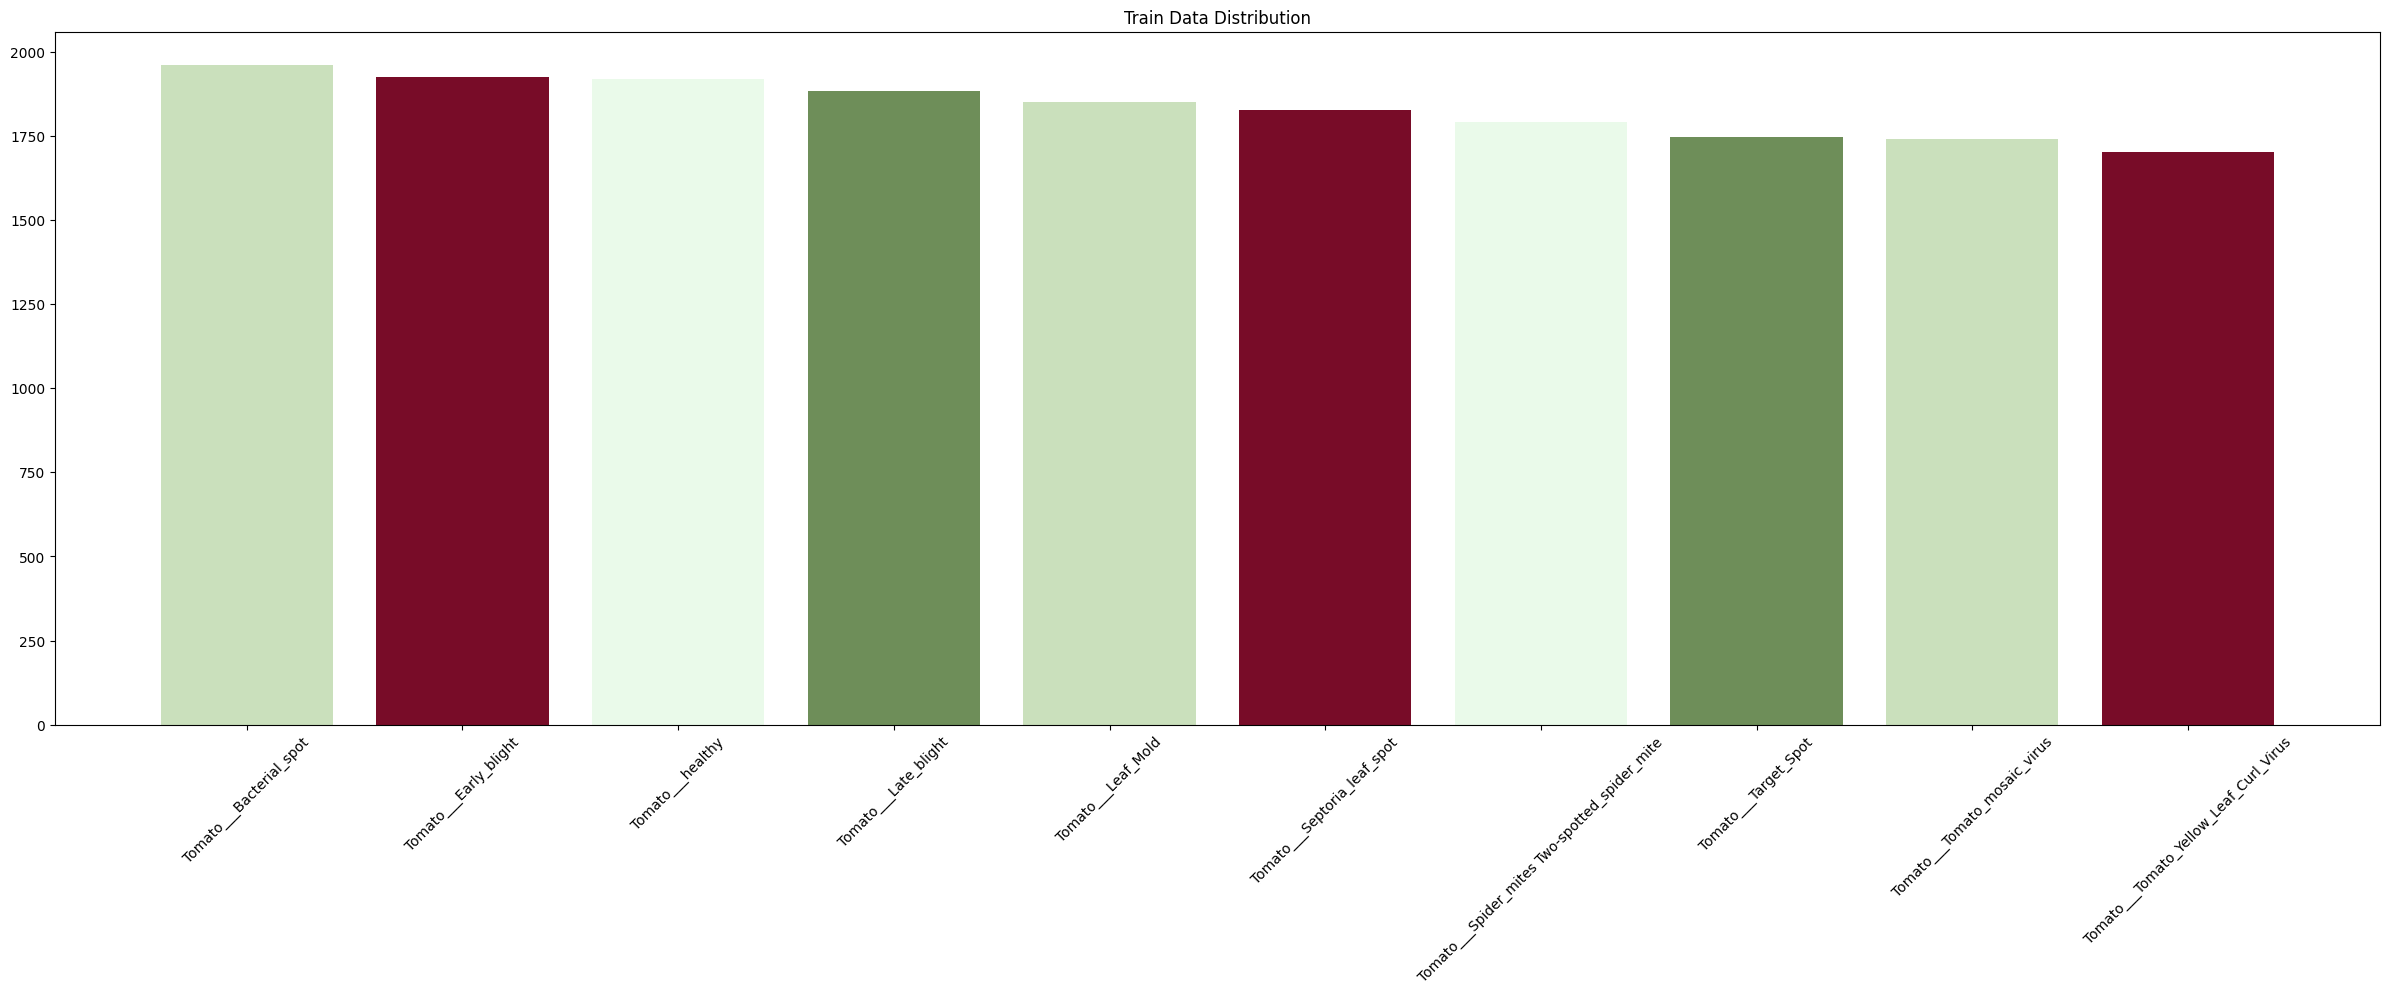

In [11]:
plt.figure(figsize=(30,9))
plt.bar(df_train['label'].unique(), df_train['label'].value_counts(), color=color)
plt.title('Train Data Distribution')
plt.xticks(rotation=45)
plt.show()

In [12]:
np.unique(label_train)

array(['Tomato___Bacterial_spot', 'Tomato___Early_blight',
       'Tomato___Late_blight', 'Tomato___Leaf_Mold',
       'Tomato___Septoria_leaf_spot',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], dtype='<U45')

Creating ImageDataGenerator for data augmentation and normalization

In [13]:
data_gen  = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# only normalization
test_gen = ImageDataGenerator(rescale=1./255)


imge_size = (224,224)
batch_size = 32

Creating data generators from DataFrames for training and validation

In [14]:
train_gen = data_gen.flow_from_dataframe(
    df_train,
    x_col='filename',
    shuffle=True,
    y_col='label',
    target_size=(imge_size[0],imge_size[1]),
    class_mode='categorical',
    batch_size=batch_size)

valid_gen = data_gen.flow_from_dataframe(
    df_valid,
    shuffle=True,
    x_col='filename',
    y_col='label',
    target_size=(imge_size[0],imge_size[1]),
    class_mode='categorical')

Found 18345 validated image filenames belonging to 10 classes.
Found 4585 validated image filenames belonging to 10 classes.


Retrieving class indices mapping from the training generator

In [15]:
class_dict = train_gen.class_indices
class_dict

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

Creating a Convolutional Neural Network (CNN) model

In [16]:
Model = Sequential([
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu', input_shape=(imge_size[0],imge_size[1],3)),
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax') ])

In [17]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,903,562 (41.59 MB)

 Trainable params: 10,900,362 (41.58 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [18]:
Model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Training the CNN model with early stopping

In [19]:
image_size = (224, 224)
batch_size = 32

data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = data_gen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_gen = data_gen.flow_from_dataframe(
    df_valid,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 18345 validated image filenames belonging to 10 classes.
Found 4585 validated image filenames belonging to 10 classes.


In [20]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='avg'
)


In [21]:
history = Model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
    )

KeyboardInterrupt: 

In [22]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(imge_size[0],imge_size[1]),
    shuffle=False,
    labels=None
)

Found 33 files.


In [32]:
Model=tf.keras.models.load_model('Modelplant_ACC97.23.h5')

In [49]:
Model.evaluate(train_gen)
Model.evaluate(valid_gen)

574/574 ━━━━━━━━━━━━━━━━━━━━ 1101s 2s/step - accuracy: 0.9385 - loss: 0.1767
144/144 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9072 - loss: 0.2344


[0.20191580057144165, 0.9264994263648987]

In [50]:
Model.save('Model2.h5')

In [51]:
preds = Model.predict(valid_gen)
y_pred = np.argmax(preds, axis=1)

144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step


Plotting a confusion matrix to visualize model performance on validation data

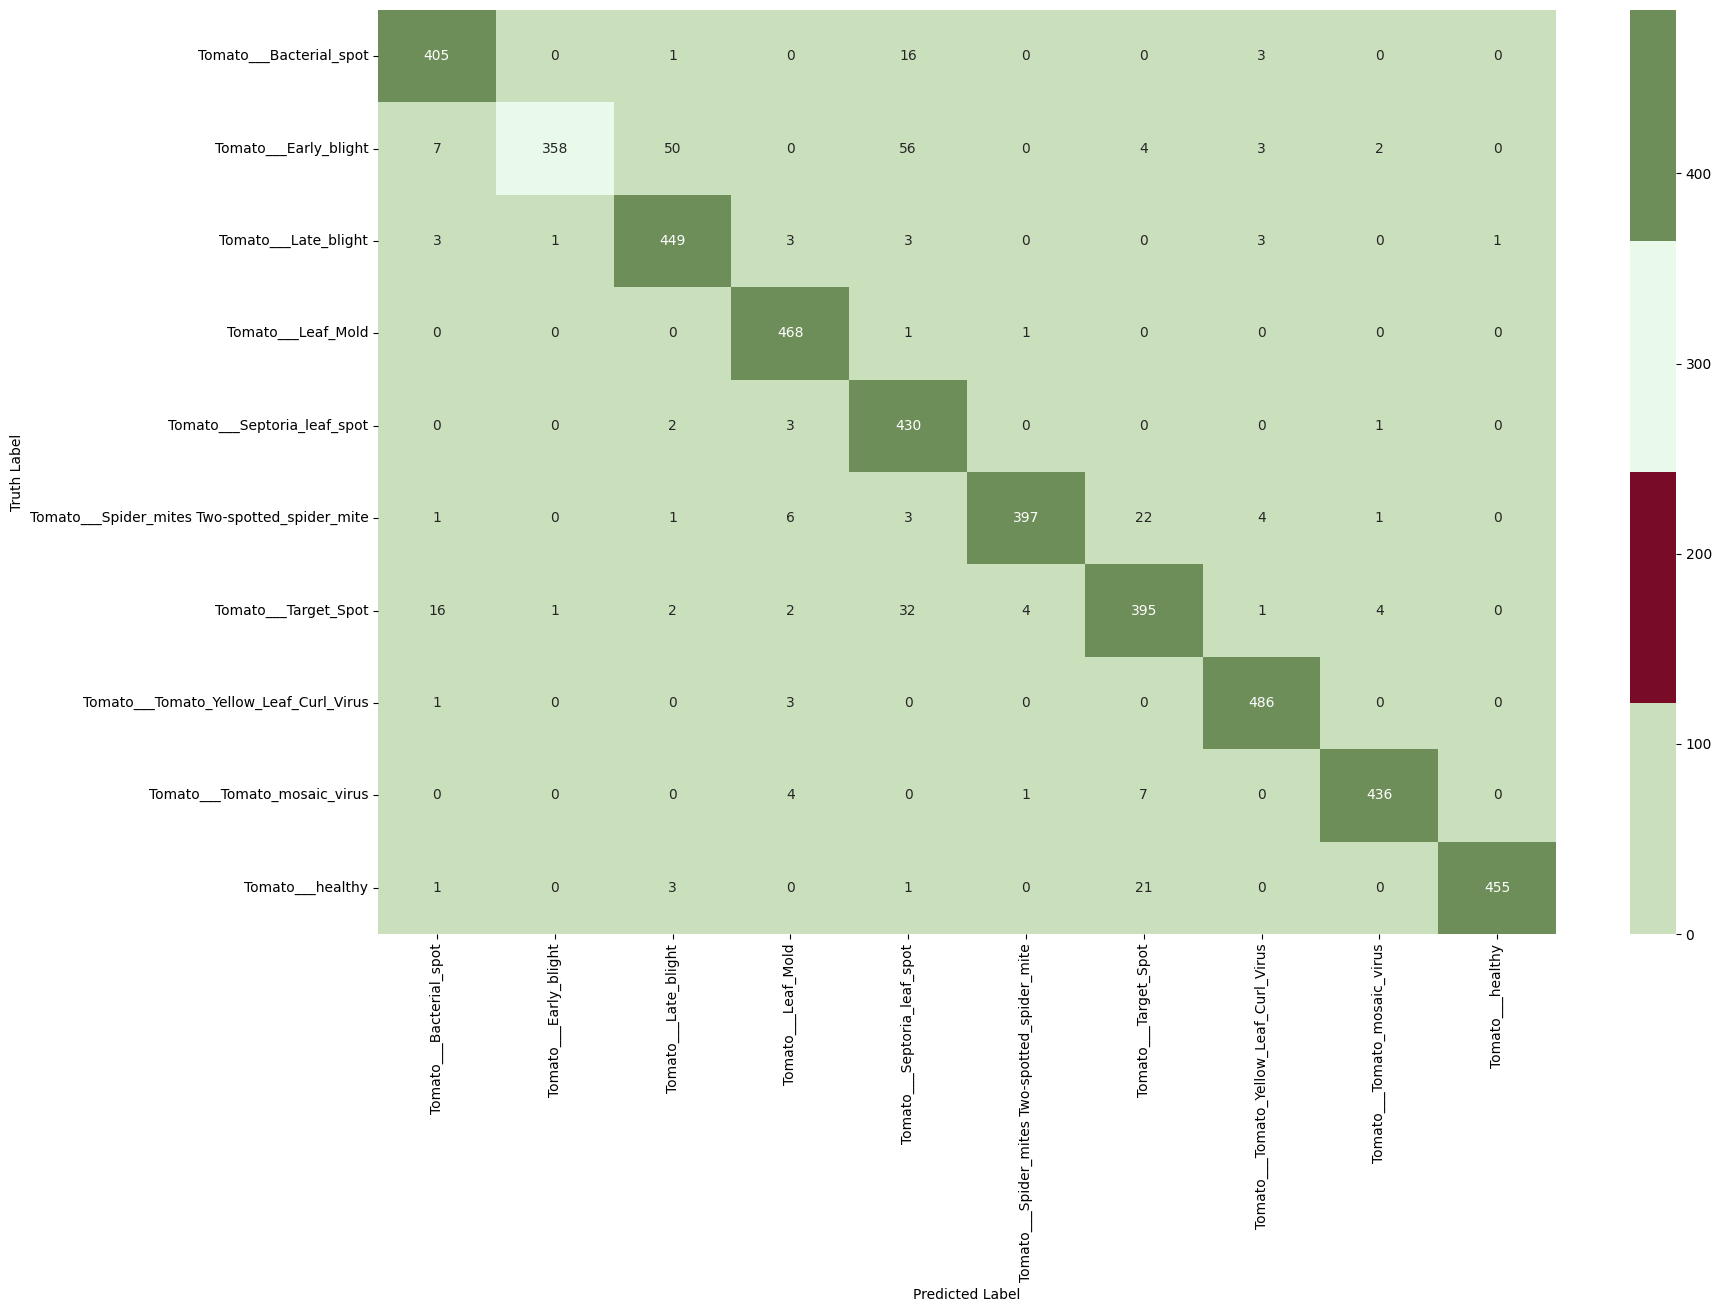

In [35]:
cm = confusion_matrix(valid_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(19,12))
sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

Plotting the training and validation accuracy and loss over epochs

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


NameError: name 'history' is not defined

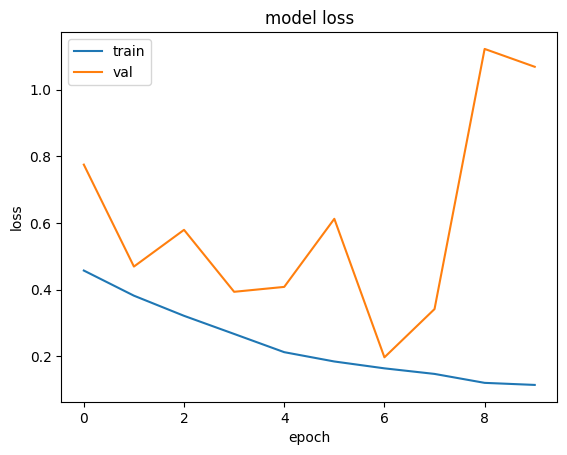

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

predict the class of an input image and visualize probabilities

In [36]:
def predict(img_path):

    
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 19))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = Model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


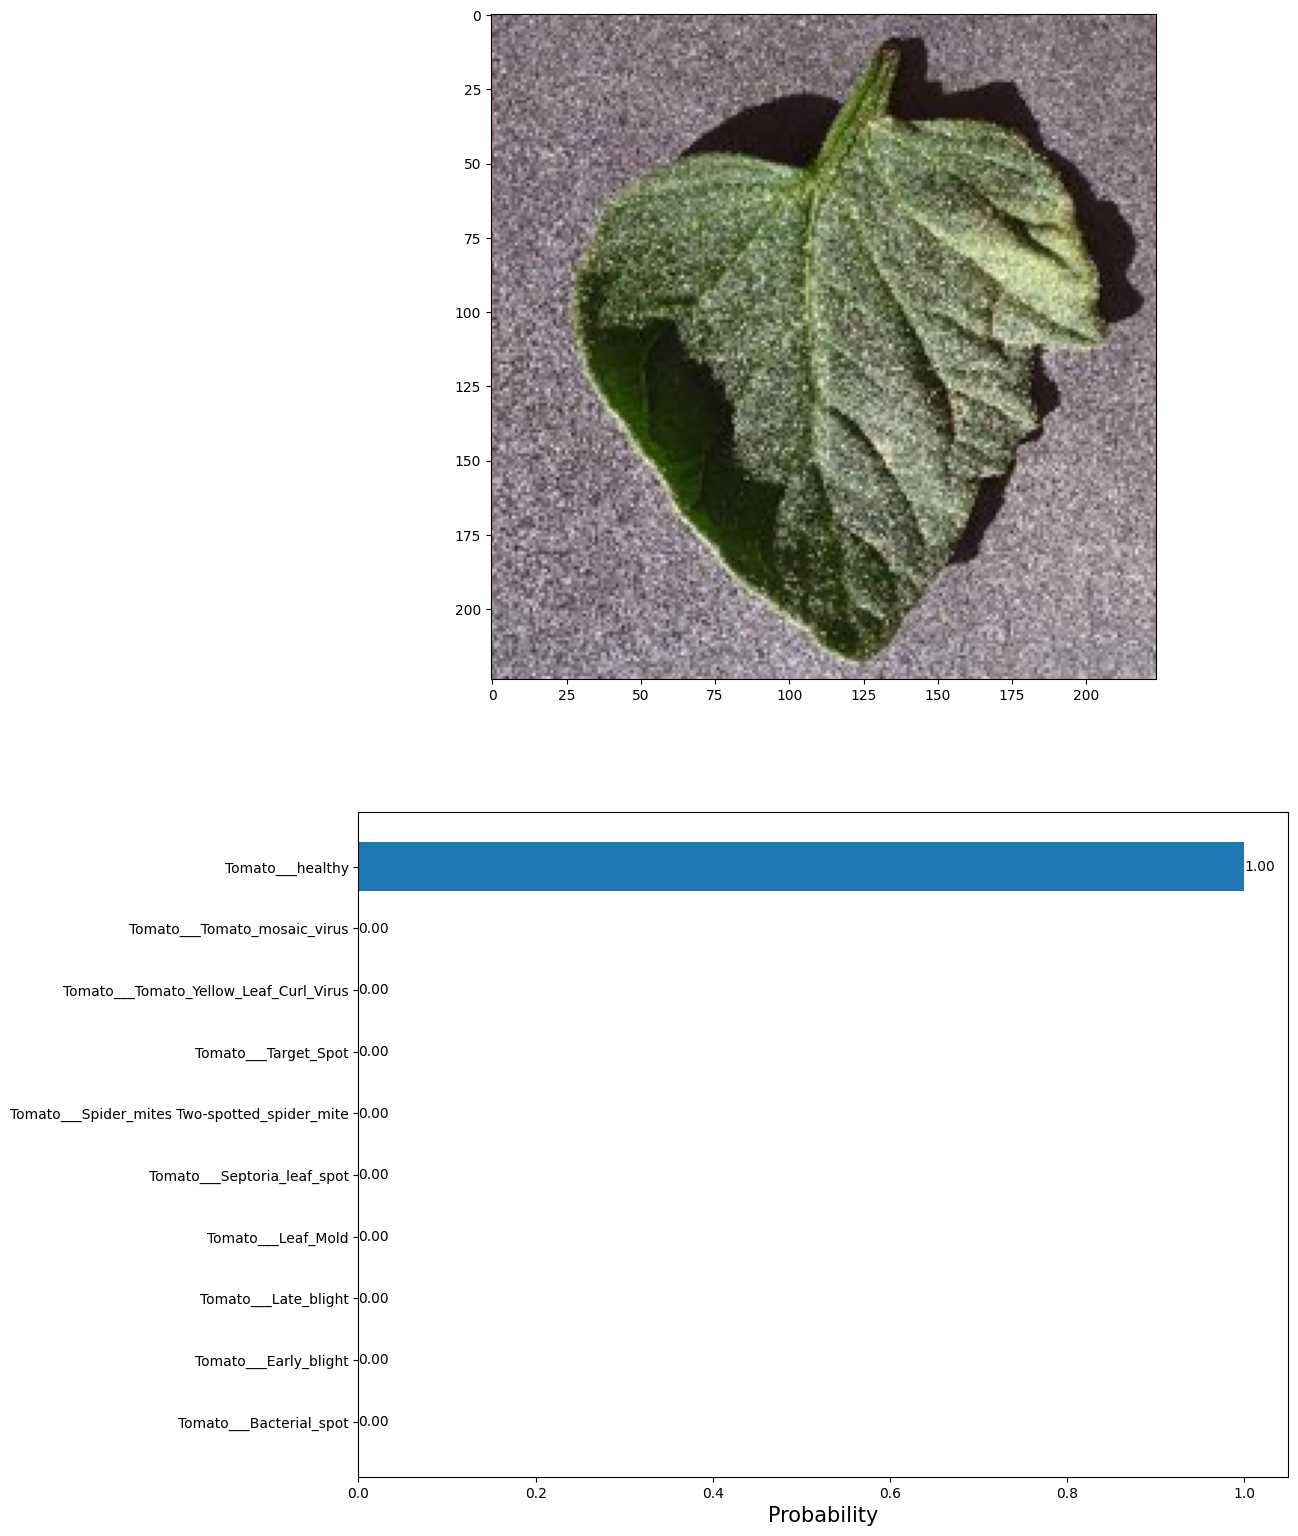

In [37]:
predict('data/test/TomatoHealthy1.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


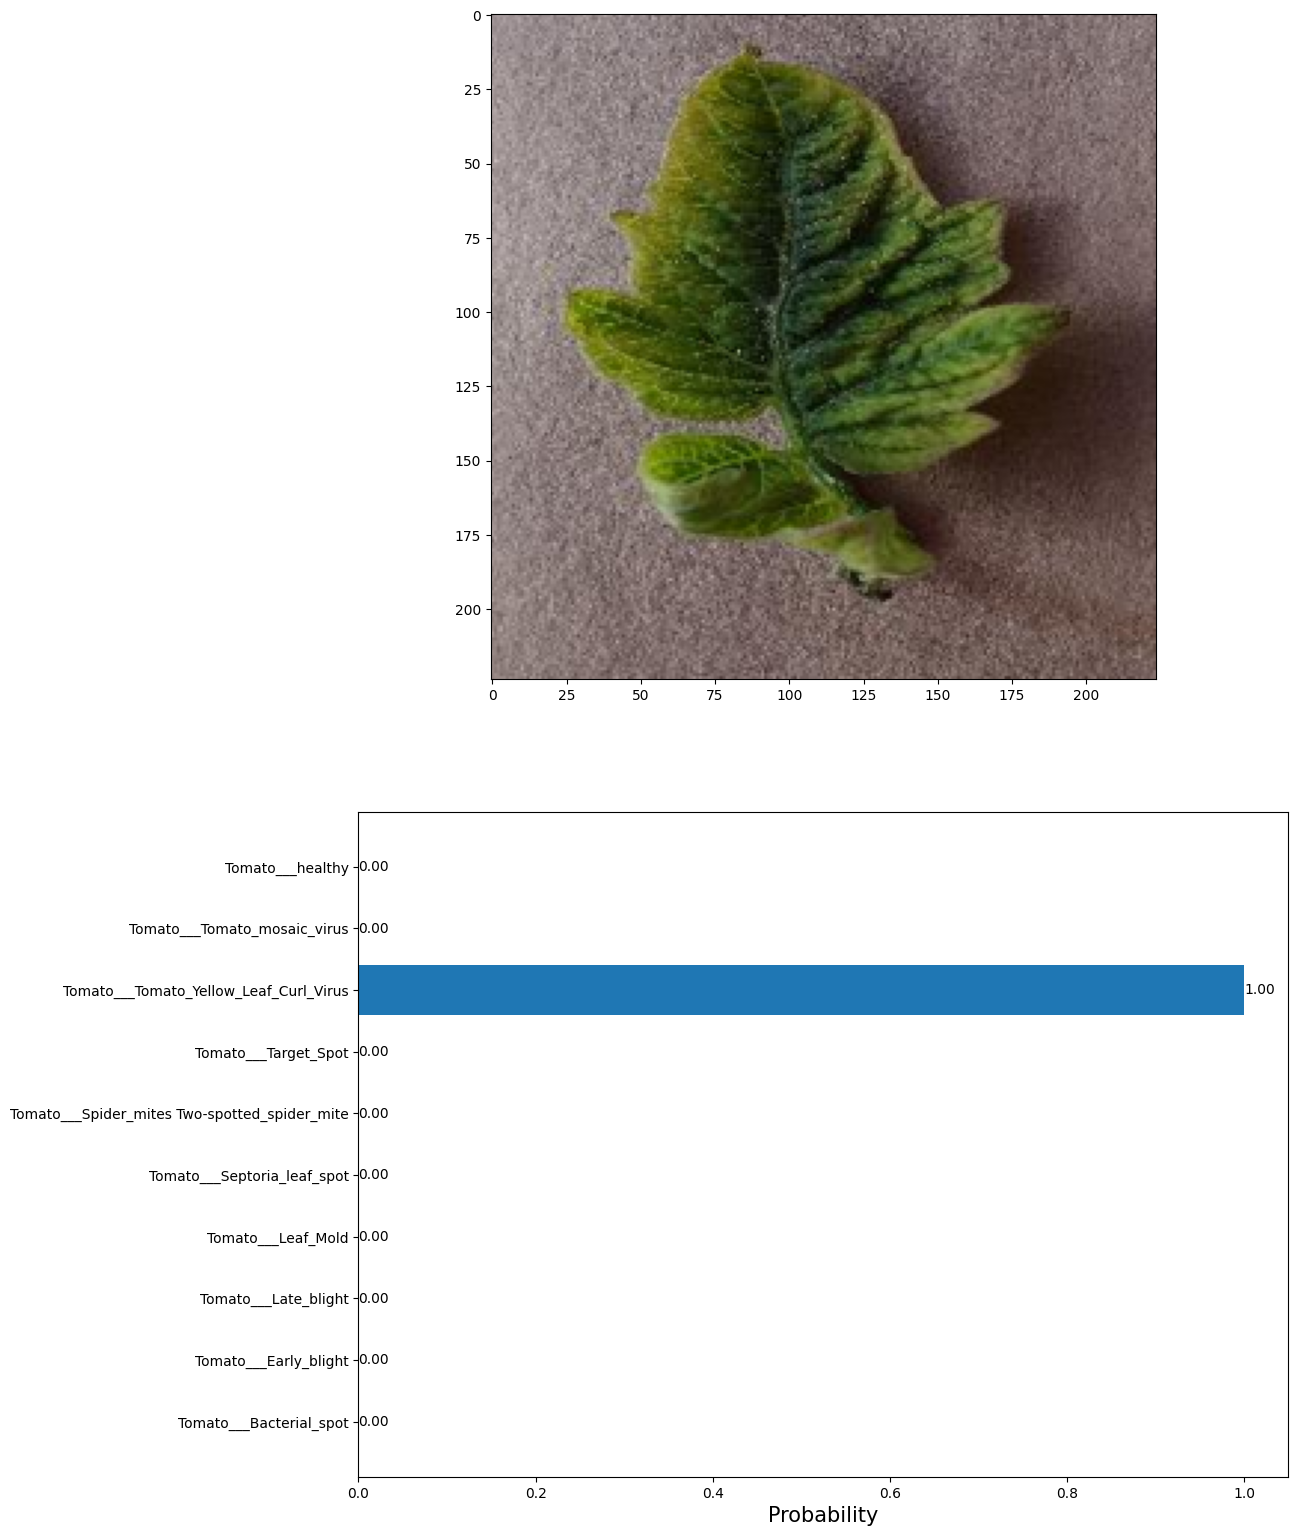

In [38]:
predict('data/test/TomatoYellowCurlVirus1.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


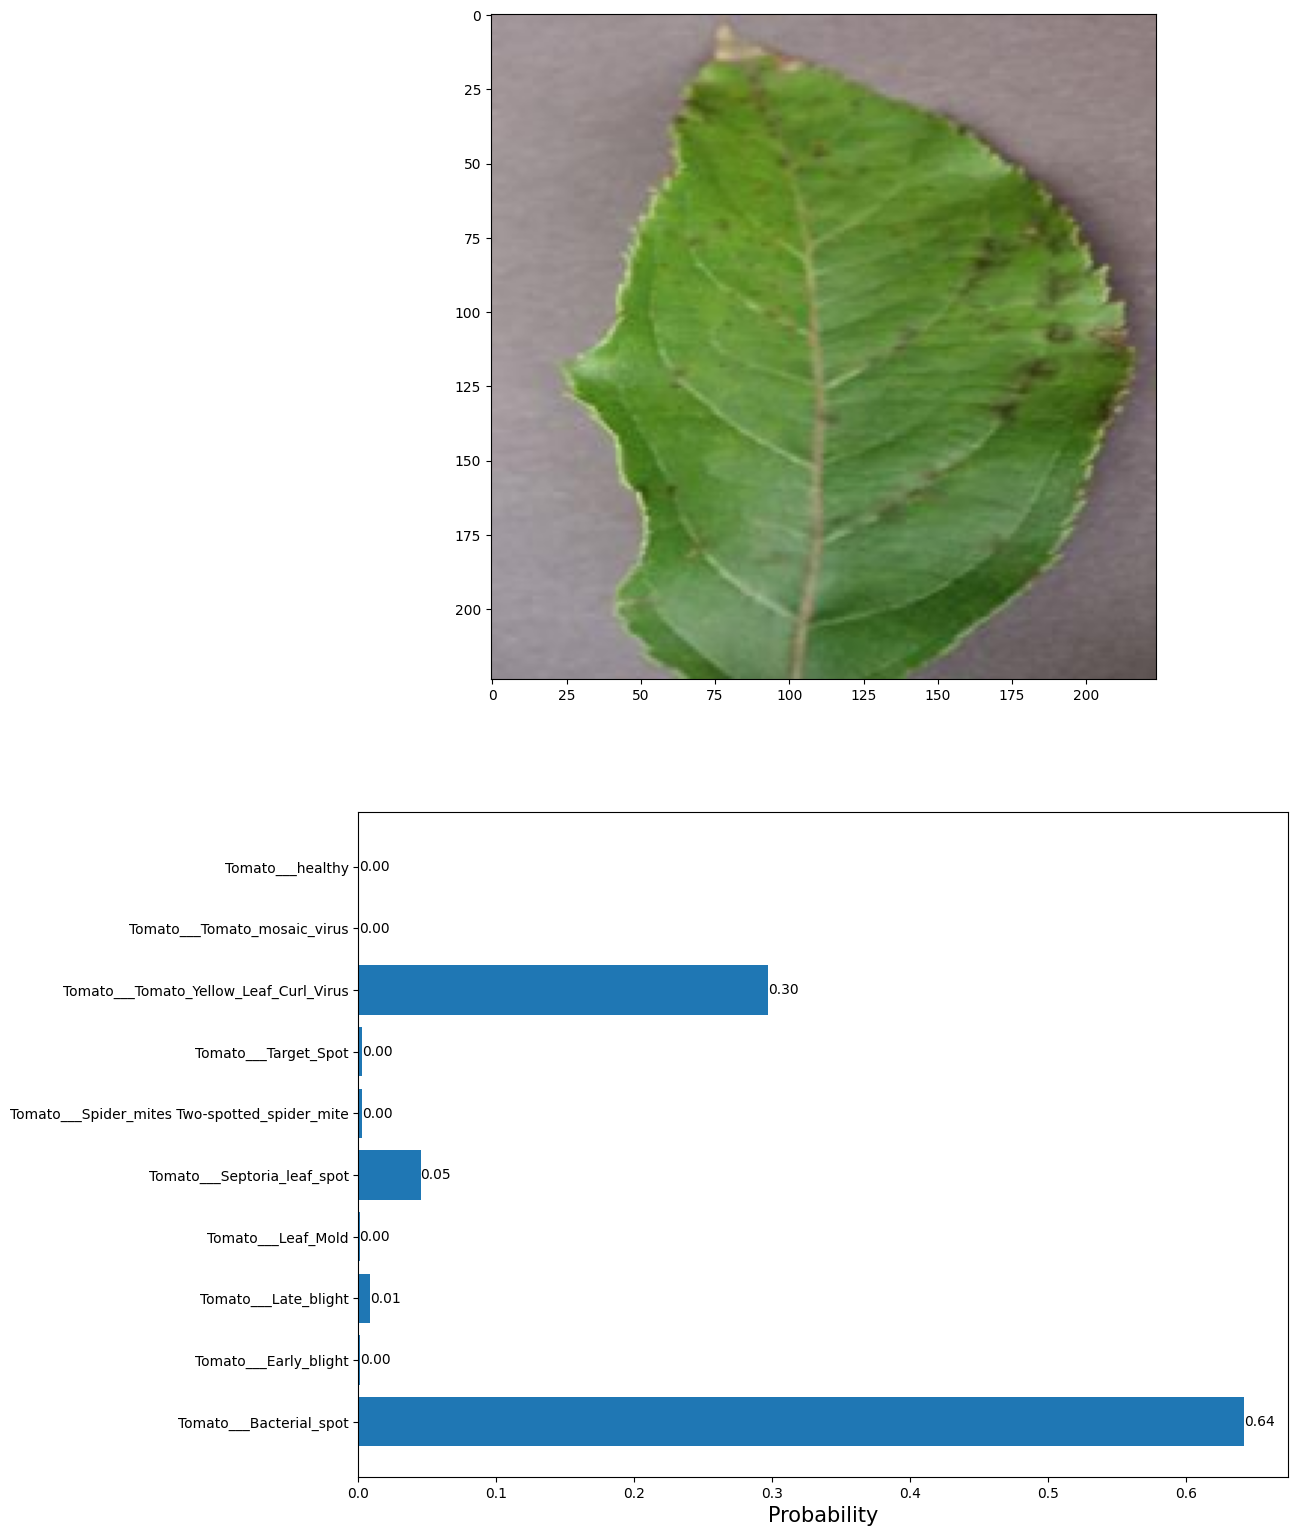

In [39]:
predict('data/test/AppleScab1.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


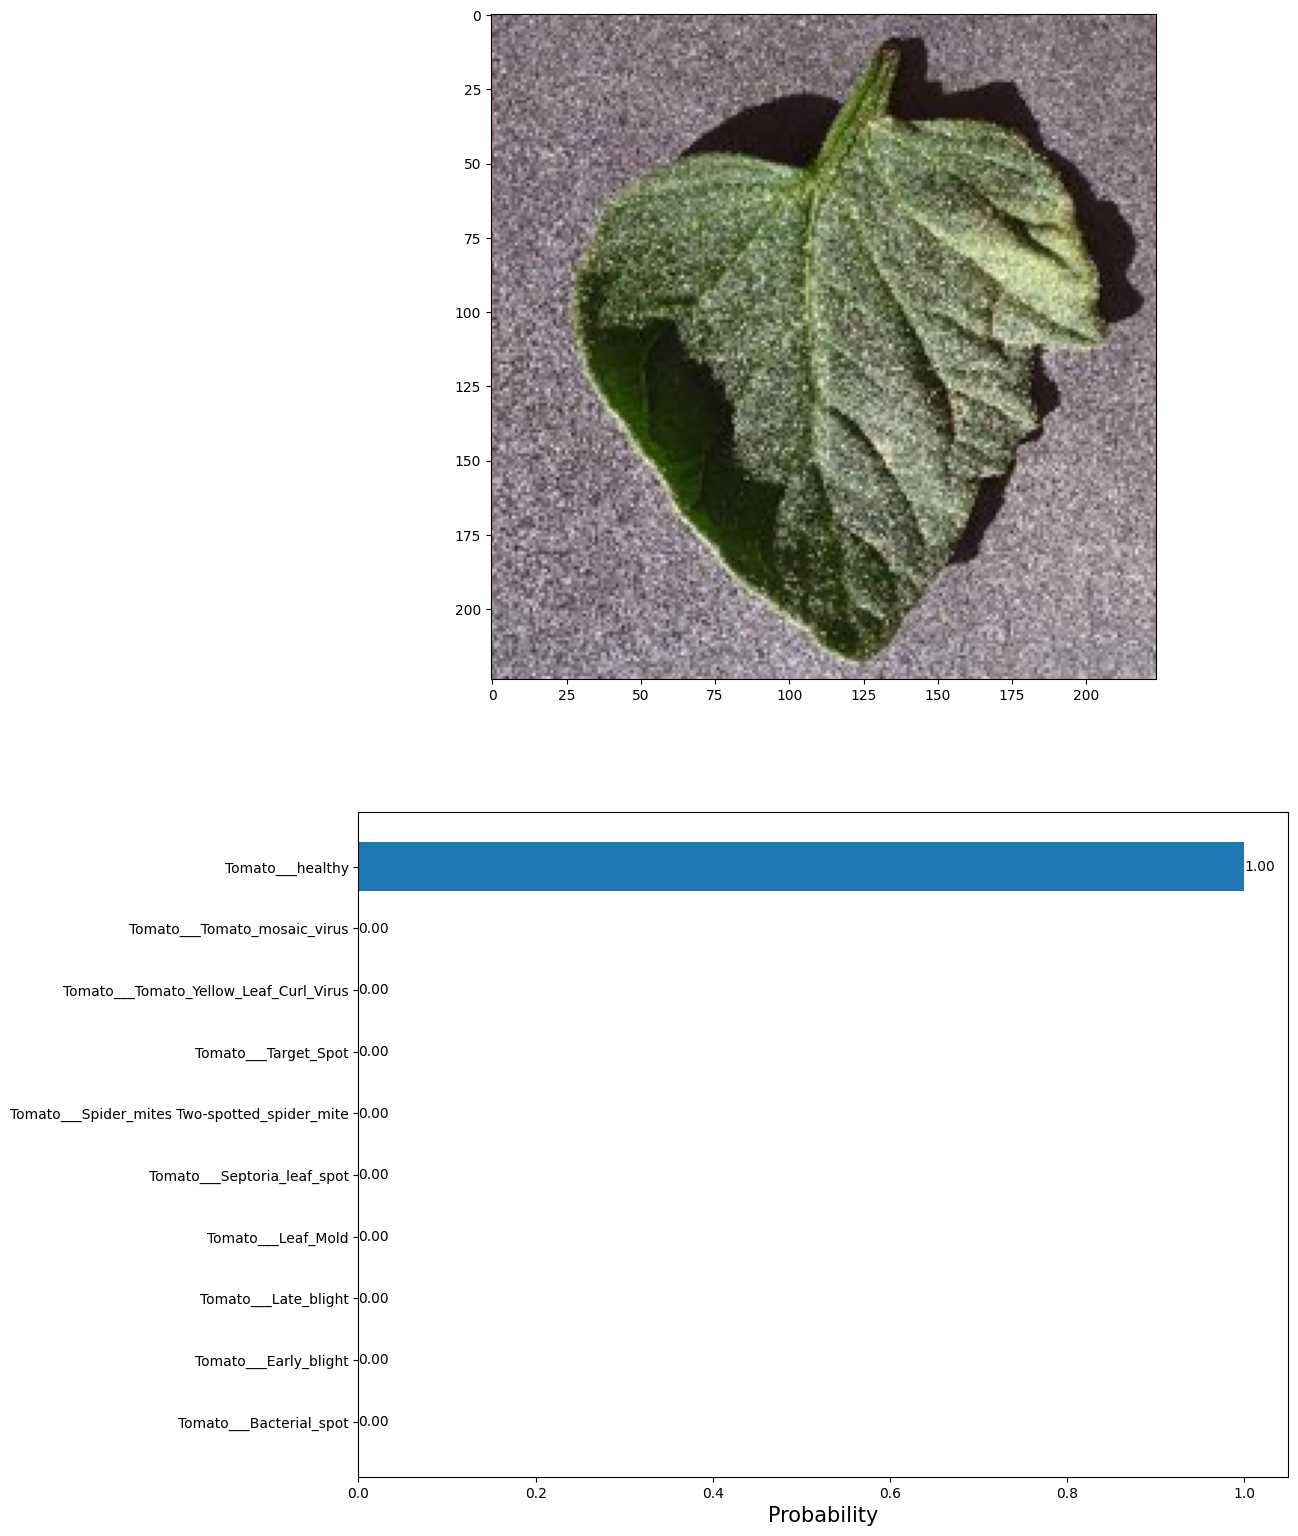

In [43]:
predict('data/test/TomatoHealthy1.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


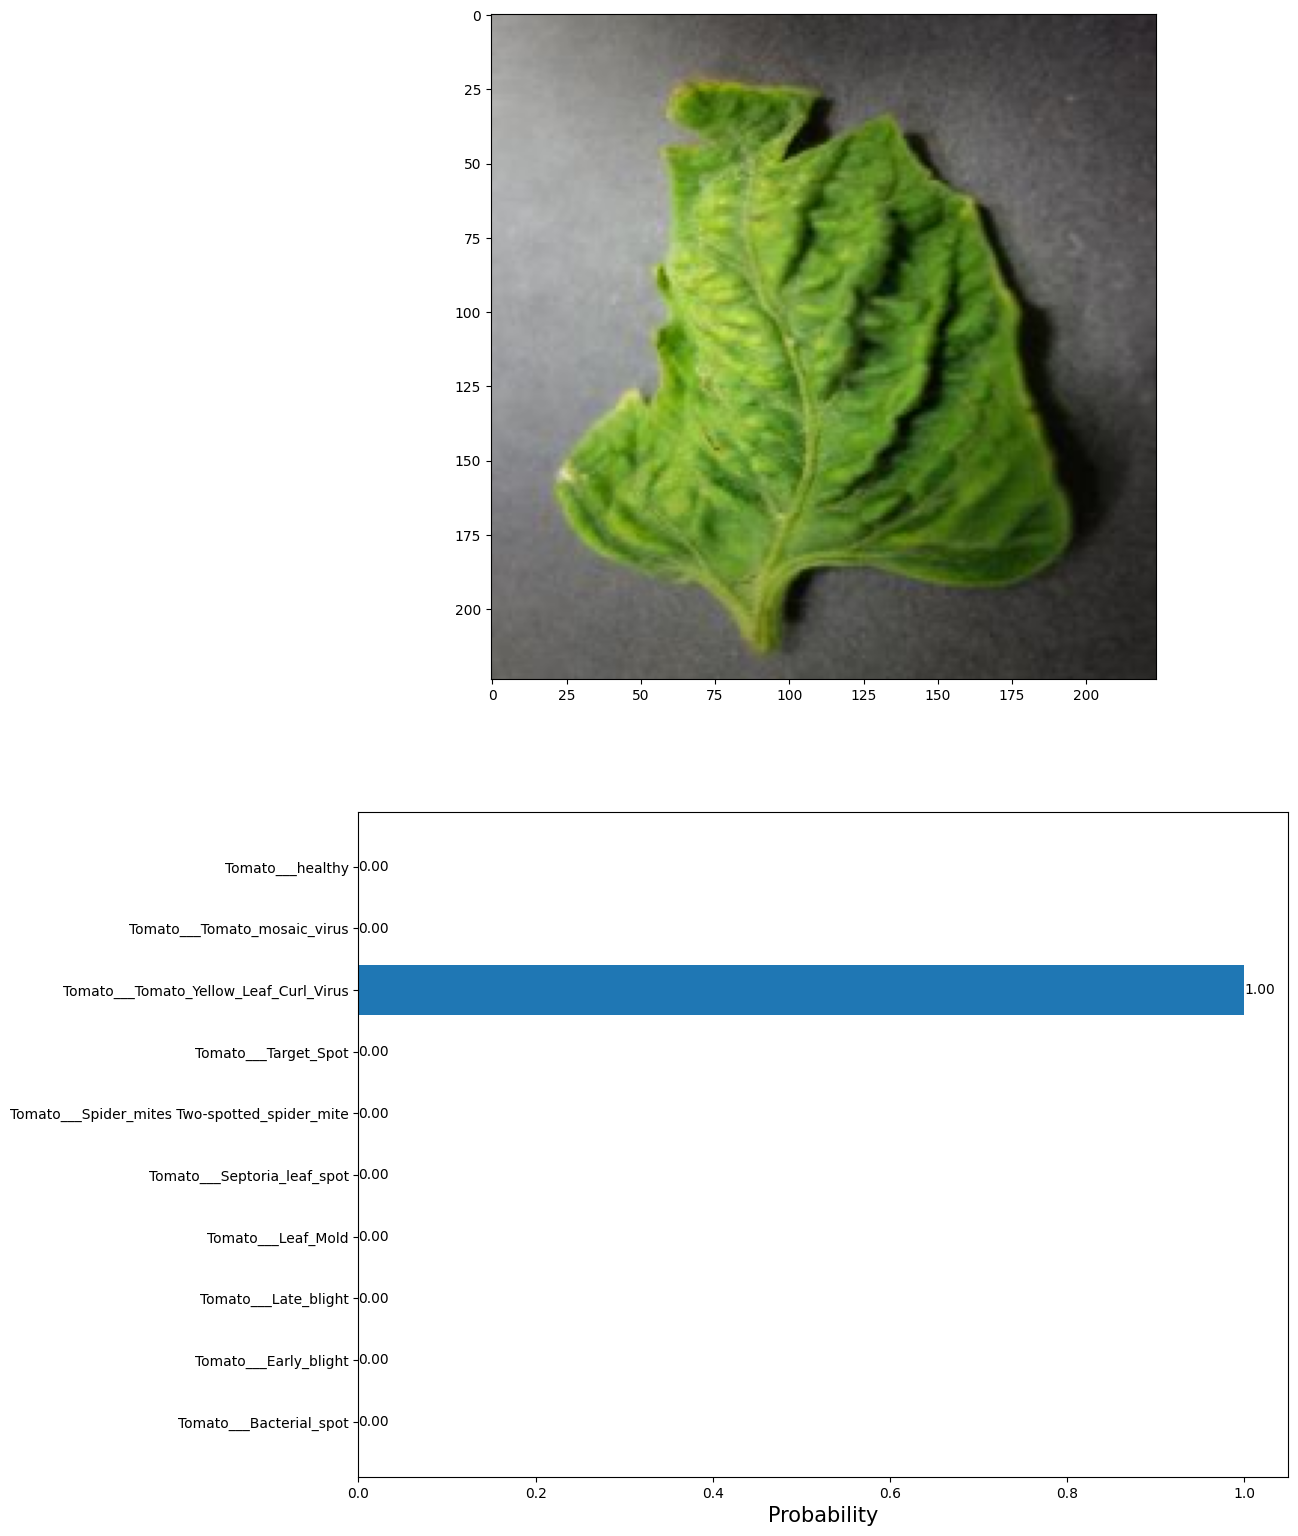

In [44]:
predict('data/test/TomatoYellowCurlVirus4.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


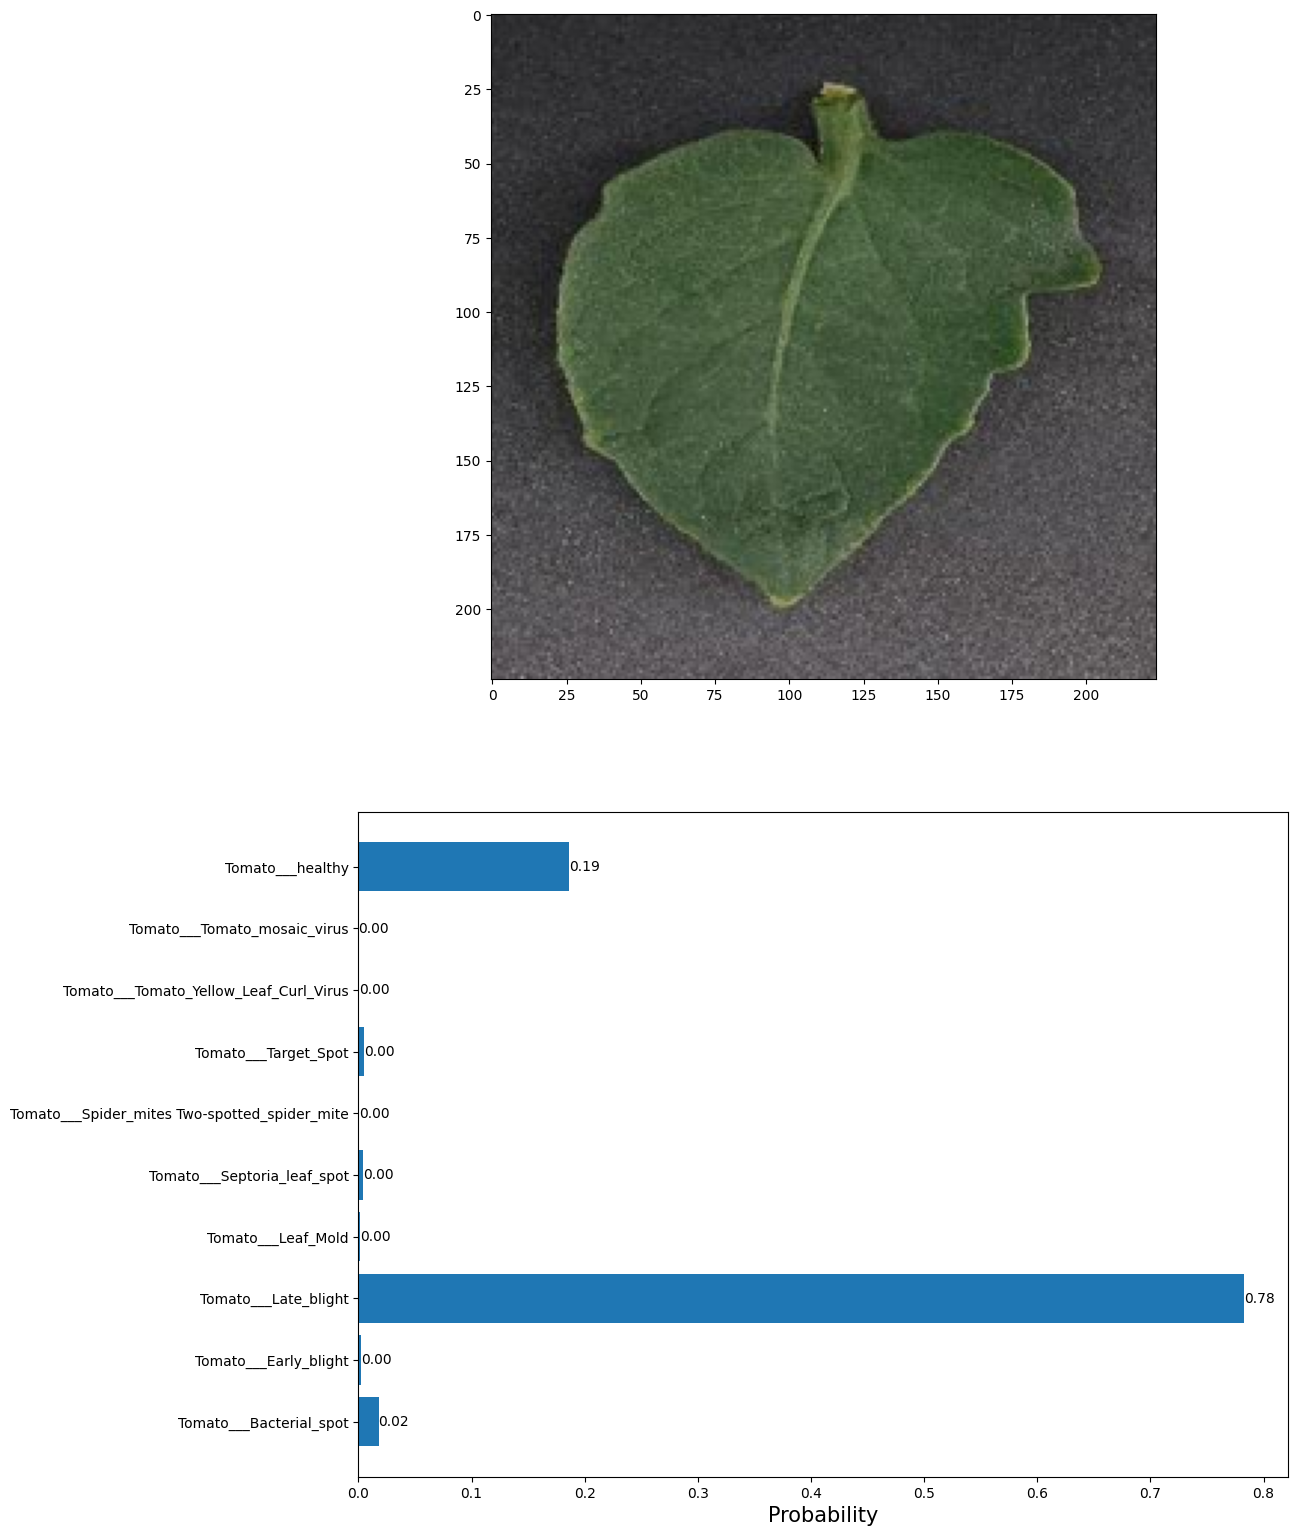

In [48]:
predict('data/test/TomatoHealthy2.JPG')